In [1]:
import numpy as np
import os
import json
import pandas as pd
import csv
from datetime import date
import matplotlib.pylab as plt
import nltk

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
import contractions

nltk.download('wordnet')
nltk.download('omw-1.4')

# preprocess
#  * pure text 2021-
#     * clean up text: stopwords, stemming, lowercase, strip urls/bad characters/HTML/etc, word-tokenization (incl. contractions), drop numbers
#     * text to vectors: BOW, also TFIDF, also word embeddings
#  * tabular 2008-21-
#     * EDA - plot distributions of interesting stuff
#     * discard / impute empty data
#     * normalize

# tasks
# * train model on numbers (e.g. profits for some years of some companies, predict future year)
# * cluster/PCA text vectors to see if industries emerge. (may need to join on external labels after the fact to measure accuracy)
# * see if model trained on text can predict financials (e.g. profit higher than cluster avg)

# for today
# * preprocess and join on 2021

# conda list -e > requirements.txt

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jainr3\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\jainr3\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
# Create list of json filenames (one per company) for Edgar reports
path_to_json = 'sec_edgar_annual_financial_filings_2021/extracted/'
json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]

# load json dicts into dataframe (rows are companies, columns are fields)
list_of_data = []

for file_name in json_files:
  with open(f'./{path_to_json}{file_name}', 'r') as f:
    data = json.load(f)
    list_of_data.append(data)

df_text = pd.DataFrame(list_of_data)
df_text["cik"] = df_text["cik"].astype(int)

# Keep only rows concerning period of 2020
REPORT_PERIOD = '2020'
df_text = df_text[df_text["period_of_report"].apply(lambda date_str: date_str[:4] == REPORT_PERIOD)].reset_index()

print(df_text.shape)
df_text.head()

(116, 34)


,index,cik,company,filing_type,filing_date,period_of_report,sic,state_of_inc,state_location,fiscal_year_end,...,item_8,item_9,item_9A,item_9B,item_10,item_11,item_12,item_13,item_14,item_15
0,0,1001601,"MGT CAPITAL INVESTMENTS, INC.",10-K,2021-04-15,2020-12-31,7374,DE,NC,1231,...,Item 8. Financial Statements and Supplementary...,Item 9. Changes in and Disagreements with Acco...,Item 9A. Controls and Procedures\nEvaluation o...,Item 9B. Other Information\nNone.\nPART III,"Item 10. Directors, Executive Officers and Cor...",Item 11. Executive Compensation\nSummary Compe...,Item 12. Security Ownership of Certain Benefic...,Item 13. Certain Relationships and Related Tra...,Item 14. Principal Accountant Fees and Service...,Item 15. Exhibits and Financial Statement Sche...
1,2,1013462,ANSYS INC,10-K,2021-02-24,2020-12-31,7372,DE,PA,1231,...,ITEM 8.FINANCIAL STATEMENTS AND SUPPLEMENTARY ...,ITEM 9.CHANGES IN AND DISAGREEMENTS WITH ACCOU...,ITEM 9A.CONTROLS AND PROCEDURES\nEvaluation of...,ITEM 9B.OTHER INFORMATION\nNone.\nPART III,"ITEM 10.DIRECTORS, EXECUTIVE OFFICERS AND CORP...",ITEM 11.EXECUTIVE COMPENSATION\nThe informatio...,ITEM 12.SECURITY OWNERSHIP OF CERTAIN BENEFICI...,ITEM 13.CERTAIN RELATIONSHIPS AND RELATED TRAN...,ITEM 14.PRINCIPAL ACCOUNTANT FEES AND SERVICES...,ITEM 15.EXHIBIT AND FINANCIAL STATEMENT SCHEDU...
2,3,1013857,PEGASYSTEMS INC,10-K,2021-02-17,2020-12-31,7374,MA,MA,1231,...,ITEM 8. FINANCIAL STATEMENTS AND SUPPLEMENTARY...,ITEM 9. CHANGES IN AND DISAGREEMENTS WITH ACCO...,ITEM 9A. CONTROLS AND PROCEDURES\nEvaluation o...,"ITEM 9B. OTHER INFORMATION\nOn February 12, 20...","ITEM 10. DIRECTORS, EXECUTIVE OFFICERS, AND CO...",ITEM 11. EXECUTIVE COMPENSATION\nThe informati...,ITEM 12. SECURITY OWNERSHIP OF CERTAIN BENEFIC...,ITEM 13. CERTAIN RELATIONSHIPS AND RELATED TRA...,ITEM 14. PRINCIPAL ACCOUNTANT FEES AND SERVICE...,ITEM 15. EXHIBITS AND FINANCIAL STATEMENT SCHE...
3,4,1015739,AWARE INC /MA/,10-K,2021-02-17,2020-12-31,7372,MA,MA,1231,...,ITEM 8. FINANCIAL STATEMENTS AND SUPPLEMENTARY...,ITEM 9. CHANGES IN AND DISAGREEMENTS WITH ACCO...,ITEM 9A. CONTROLS AND PROCEDURES\nConclusion R...,ITEM 9B. OTHER INFORMATION\nNone.\nPART III,"ITEM 10. DIRECTORS, EXECUTIVE OFFICERS AND COR...",ITEM 11. EXECUTIVE COMPENSATION\nThe informati...,ITEM 12. SECURITY OWNERSHIP OF CERTAIN BENEFIC...,ITEM 13. CERTAIN RELATIONSHIPS AND RELATED TRA...,ITEM 14. PRINCIPAL ACCOUNTANT FEES AND SERVICE...,ITEM 15. EXHIBITS AND FINANCIAL STATEMENT SCHE...
4,5,1017655,PAID INC,10-K,2021-03-31,2020-12-31,7389,DE,MA,1231,...,Item 8. Financial Statements and Supplementary...,Item 9. Changes in and Disagreements with Acco...,Item 9A. Controls and Procedures\nEvaluation o...,Item 9B. Other Information\nNot applicable.\nP...,"Item 10. Directors, Executive Officers and Cor...","Item 11. Executive Compensation\nOn May 10, 20...",Item 12. Security Ownership of Certain Benefic...,Item 13. Certain Relationships and Related Tra...,Item 14. Principal Accountant Fees and Service...,Item 15. Exhibits and Financial Statement Sche...


In [3]:
# Preprocessing the df_text
text_columns = ['item_1', 'item_1A', 'item_1B', 'item_2', 'item_3',
                'item_4', 'item_5', 'item_6', 'item_7', 'item_7A', 'item_8', 'item_9',
                'item_9A', 'item_9B', 'item_10', 'item_11', 'item_12', 'item_13',
                'item_14', 'item_15']

def lemmatize_text(text):
  w_tokenizer = WhitespaceTokenizer()
  lemmatizer = WordNetLemmatizer()
  return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

for col in text_columns:
  # Make everything lowercase
  df_text[col] = df_text[col].str.lower()
  # Replace all the special characters with spaces
  # HTML Tags, random escape characters (newline, tab)
  df_text[col] = df_text[col].str.replace(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});', ' ', regex=True)
  df_text[col] = df_text[col].str.replace(r'\n', ' ', regex=True)
  df_text[col] = df_text[col].str.replace(r'\t', ' ', regex=True)
  # https://stackoverflow.com/a/23996414 
  # Keep non-special characters blanket regex
  df_text[col] = df_text[col].str.replace(r'[^a-zA-Z0-9 \n\.]', ' ', regex=True)
  # Replace contractions
  df_text[col] = df_text[col].apply(lambda x: contractions.fix(x))
  # Strip punctuation
  df_text[col] = df_text[col].str.replace(r'[^\w\s]',' ', regex=True)

  # Now remove stop words
  stop = stopwords.words('english')
  pat = r'\b(?:{})\b'.format('|'.join(stop))
  df_text[col] = df_text[col].str.replace(pat, ' ', regex=True)
  # Handles any empty space between words / due to replacements
  df_text[col] = df_text[col].str.replace(r'\s+', ' ', regex=True)

  # Remove numbers
  df_text[col] = df_text[col].str.replace('\d+', ' ', regex=True)

  # Lemmatize text 
  df_text[col] = df_text[col].apply(lemmatize_text)

# Example tokenized text field
df_text['item_1'][0]

# Non tokenized version
df_text_non_tokenized = df_text.copy()
for col in text_columns:
  df_text_non_tokenized[col] = df_text_non_tokenized[col].str.join(" ")


In [4]:
# Create list of json filenames (one per company) for SEC data made usable tables
path_to_csv = 'sec_company_facts_all_10Q_and_10K_financial_data/sec_data_made_useable/sec_data_made_useable/'
csv_files = [pos_json for pos_json in os.listdir(path_to_csv) if pos_json.endswith('.csv')]

list_of_data = []

NUM_FILES = -1  # only parse first N files

for file_name in csv_files[:NUM_FILES]:
  with open(f'./{path_to_csv}{file_name}', 'r') as f:
    data = list(csv.DictReader(f, delimiter=','))

    # each row is one filing year for the same company
    for year_data in data:
      # print(type(int(year_data["CIK"][3:])))
      # print(type(df_text["cik"][0]))

      if (
        year_data["end"][:4] == REPORT_PERIOD and
        year_data["form"] == "10-K" and
        year_data["Currency"] == "USD" and
        int(year_data["CIK"][3:]) in df_text["cik"].values
      ):
        list_of_data.append(year_data)

df_table_raw = pd.DataFrame(list_of_data).replace('', np.nan)
df_table = df_table_raw.drop(['end', 'filed', 'form', 'Ticker', 'Currency', 'Name'], axis=1)
df_table["CIK"] = df_table["CIK"].apply(lambda cik: int(cik[3:]))

print(df_table.shape)
df_table.head()

(104, 3341)


,CIK,AccountsPayableCurrent,AccountsReceivableNetCurrent,AccruedIncomeTaxesCurrent,AccruedLiabilitiesCurrent,AccumulatedDepreciationDepletionAndAmortizationPropertyPlantAndEquipment,AccumulatedOtherComprehensiveIncomeLossAvailableForSaleSecuritiesAdjustmentNetOfTax,AccumulatedOtherComprehensiveIncomeLossNetOfTax,AdditionalPaidInCapital,AdditionalPaidInCapitalCommonStock,...,DebtSecuritiesAvailableForSaleAmortizedCostAfterAllowanceForCreditLoss,EffectiveIncomeTaxRateReconciliationMinorityInterestIncomeExpense,EffectiveIncomeTaxRateReconciliationTaxCreditsOther,MembersCapital,SharebasedCompensationArrangementBySharebasedPaymentAwardAcceleratedVestingNumber,DeferredPolicyAcquisitionCostsAdditions,ContractWithCustomerRightToRecoverProductCurrent,IncomeTaxReconciliationNondeductibleExpenseRestructuringCharges,PurchaseObligationDueInFourthAndFifthYear,PurchaseObligationDueInSecondAndThirdYear
0,320340,714000.0,3270000.0,954000.0,321000.0,5395000.0,NaN,-140000.0,NaN,15836000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,736012,408000.0,1233000.0,NaN,628000.0,1097000.0,NaN,-43000.0,77187000.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,746210,313000.0,3166000.0,NaN,1201000.0,10986000.0,NaN,NaN,NaN,215092000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,796343,306000000.0,1398000000.0,63000000.0,1422000000.0,1458000000.0,6000000.0,-158000000.0,7357000000.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,814549,NaN,142847000.0,3429000.0,NaN,26015000.0,NaN,-101503000.0,11126000.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

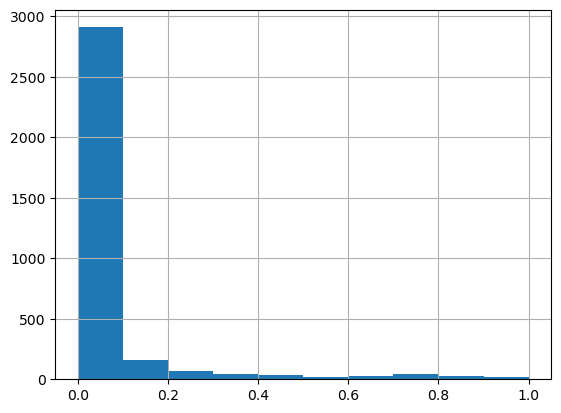

In [5]:
# We can see that there are a huge number of fields, but almost all of them are missing
# (because they are for 10-Qs or other forms)
(df_table.count(axis=0) / df_table.shape[0]).hist()

14
Index(['CIK', 'Assets', 'AssetsCurrent',
       'CashAndCashEquivalentsAtCarryingValue',
       'DeferredTaxAssetsValuationAllowance',
       'LiabilitiesAndStockholdersEquity', 'LiabilitiesCurrent',
       'NetCashProvidedByUsedInFinancingActivities',
       'NetCashProvidedByUsedInInvestingActivities',
       'NetCashProvidedByUsedInOperatingActivities', 'NetIncomeLoss',
       'OperatingIncomeLoss', 'RetainedEarningsAccumulatedDeficit',
       'StockholdersEquity'],
      dtype='object')


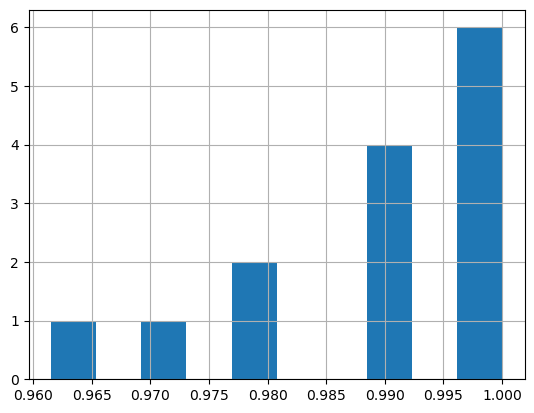

In [6]:
# What if we only took the fields that were filled out for a high percent of the companies?
FILLED_PCT_MIN = 0.95
field_filled_pct = df_table.count(axis=0) / df_table.shape[0]
df_table = df_table.loc[:, field_filled_pct >= FILLED_PCT_MIN]
print(len(df_table.columns))

# After manual inspection of these, we were reasonably happy that they captured many of the "most important" values
print(df_table.columns)

(df_table.count(axis=0) / df_table.shape[0]).hist()

# Keep only some selected columns based on their distribution
selected_cols_table = ["CIK", "Assets", "AssetsCurrent", "CashAndCashEquivalentsAtCarryingValue", "DeferredTaxAssetsValuationAllowance",
"LiabilitiesAndStockholdersEquity", "LiabilitiesCurrent", "StockholdersEquity"]

df_table = df_table[selected_cols_table]

# np.log(df_table["LiabilitiesAndStockholdersEquity"].astype(float)).hist()

C:\Users\jainr3\AppData\Local\Temp\ipykernel_2436\57063981.py:5: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_table.iloc[:, 1:] = simp.fit_transform(df_table.iloc[:, 1:])


array([[<AxesSubplot:title={'center':'Assets'}>,
        <AxesSubplot:title={'center':'AssetsCurrent'}>,
        <AxesSubplot:title={'center':'CashAndCashEquivalentsAtCarryingValue'}>],
       [<AxesSubplot:title={'center':'DeferredTaxAssetsValuationAllowance'}>,
        <AxesSubplot:title={'center':'LiabilitiesAndStockholdersEquity'}>,
        <AxesSubplot:title={'center':'LiabilitiesCurrent'}>],
       [<AxesSubplot:title={'center':'StockholdersEquity'}>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

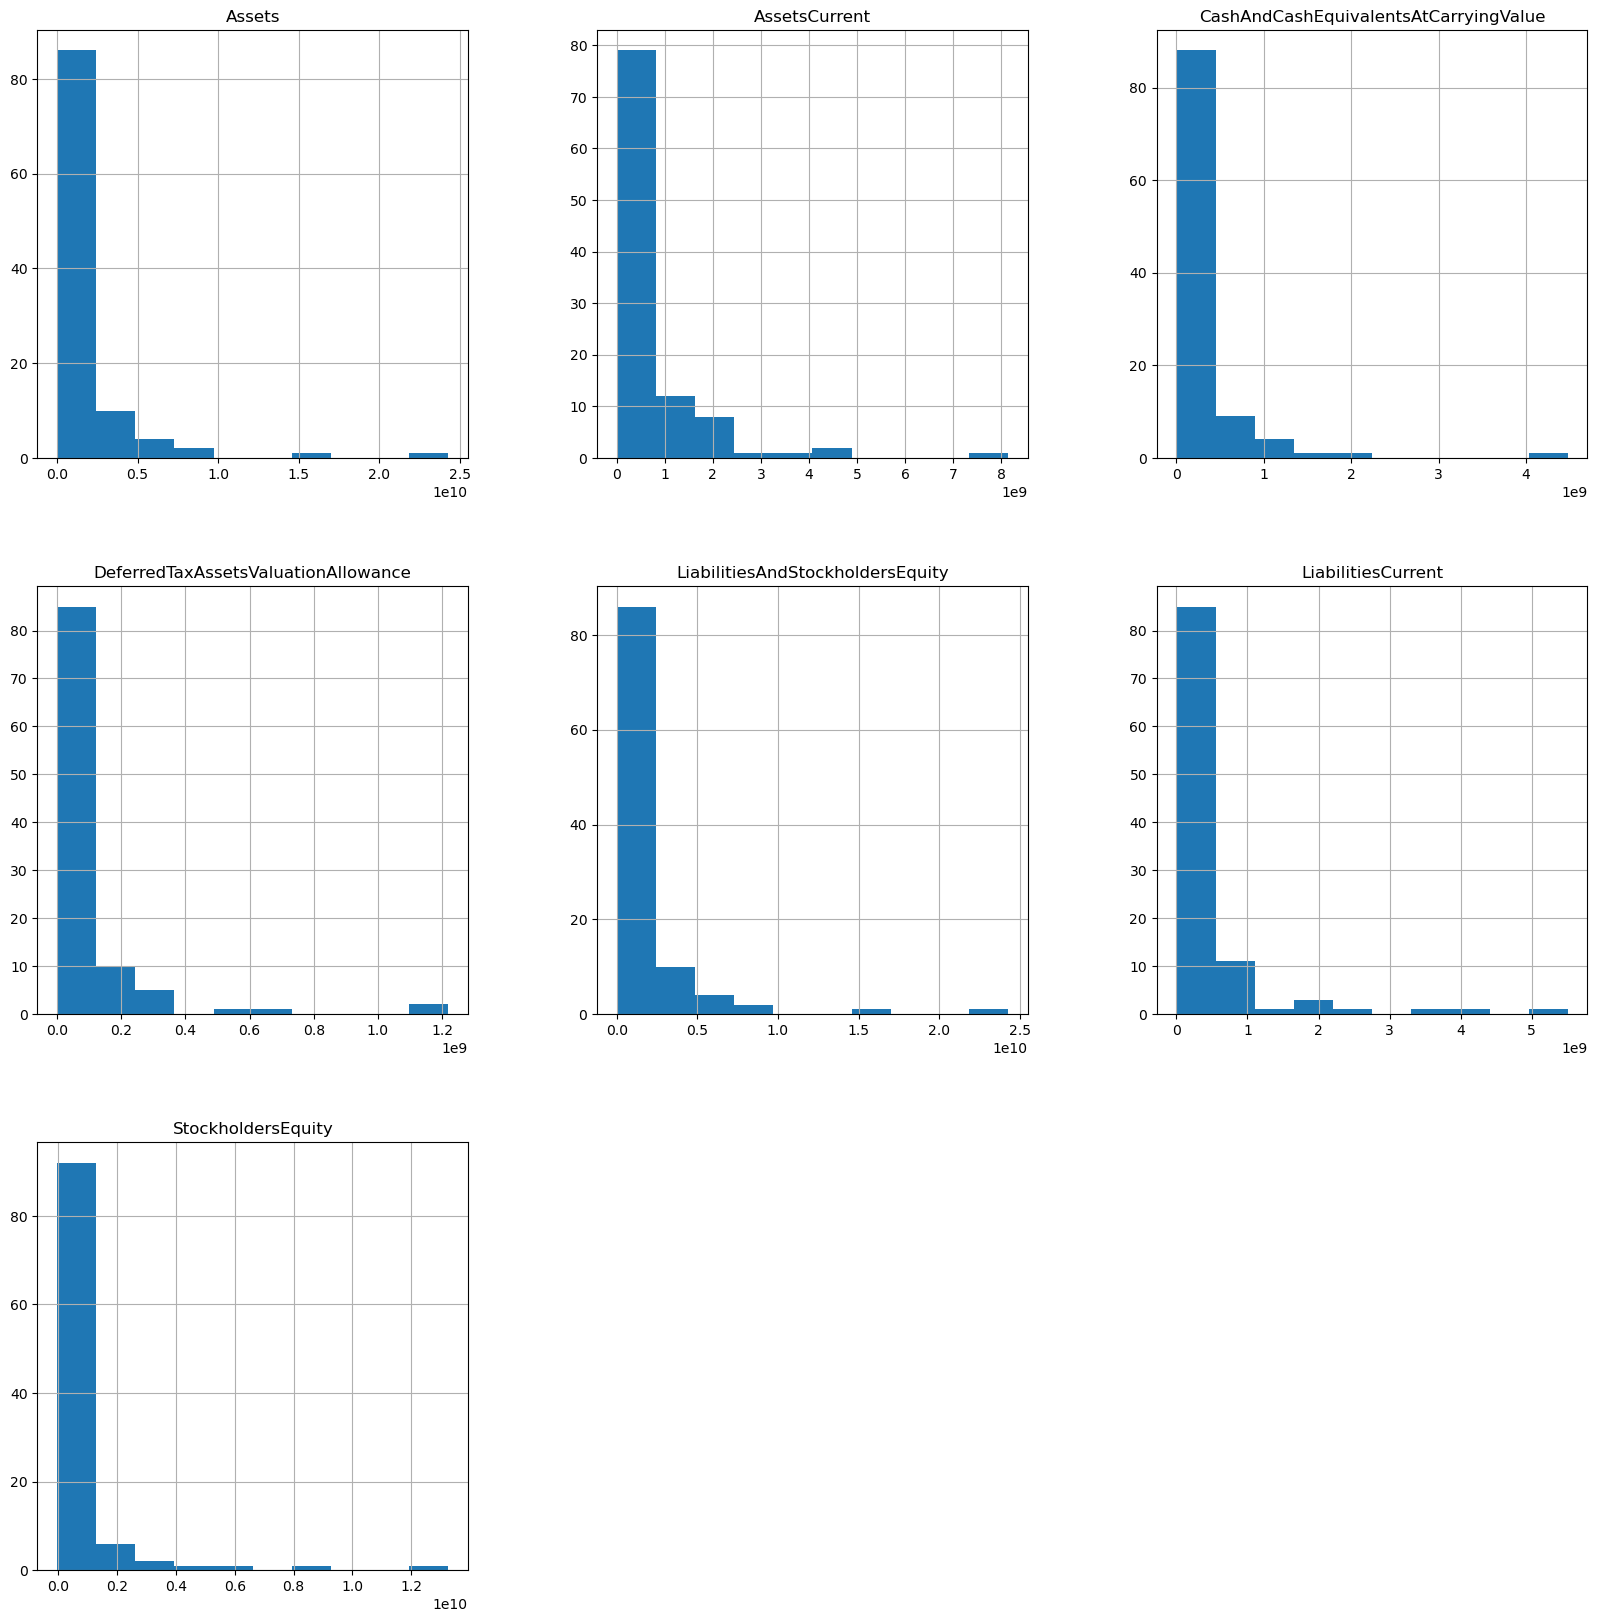

In [7]:
from sklearn.impute import SimpleImputer

# Impute missing values as median
simp = SimpleImputer(strategy='median')
df_table.iloc[:, 1:] = simp.fit_transform(df_table.iloc[:, 1:])

# Visualize distribution of all fields
df_table.iloc[:, 1:].hist(figsize=(20, 20))

array([[<AxesSubplot:title={'center':'Assets'}>,
        <AxesSubplot:title={'center':'AssetsCurrent'}>,
        <AxesSubplot:title={'center':'CashAndCashEquivalentsAtCarryingValue'}>],
       [<AxesSubplot:title={'center':'DeferredTaxAssetsValuationAllowance'}>,
        <AxesSubplot:title={'center':'LiabilitiesAndStockholdersEquity'}>,
        <AxesSubplot:title={'center':'LiabilitiesCurrent'}>],
       [<AxesSubplot:title={'center':'StockholdersEquity'}>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

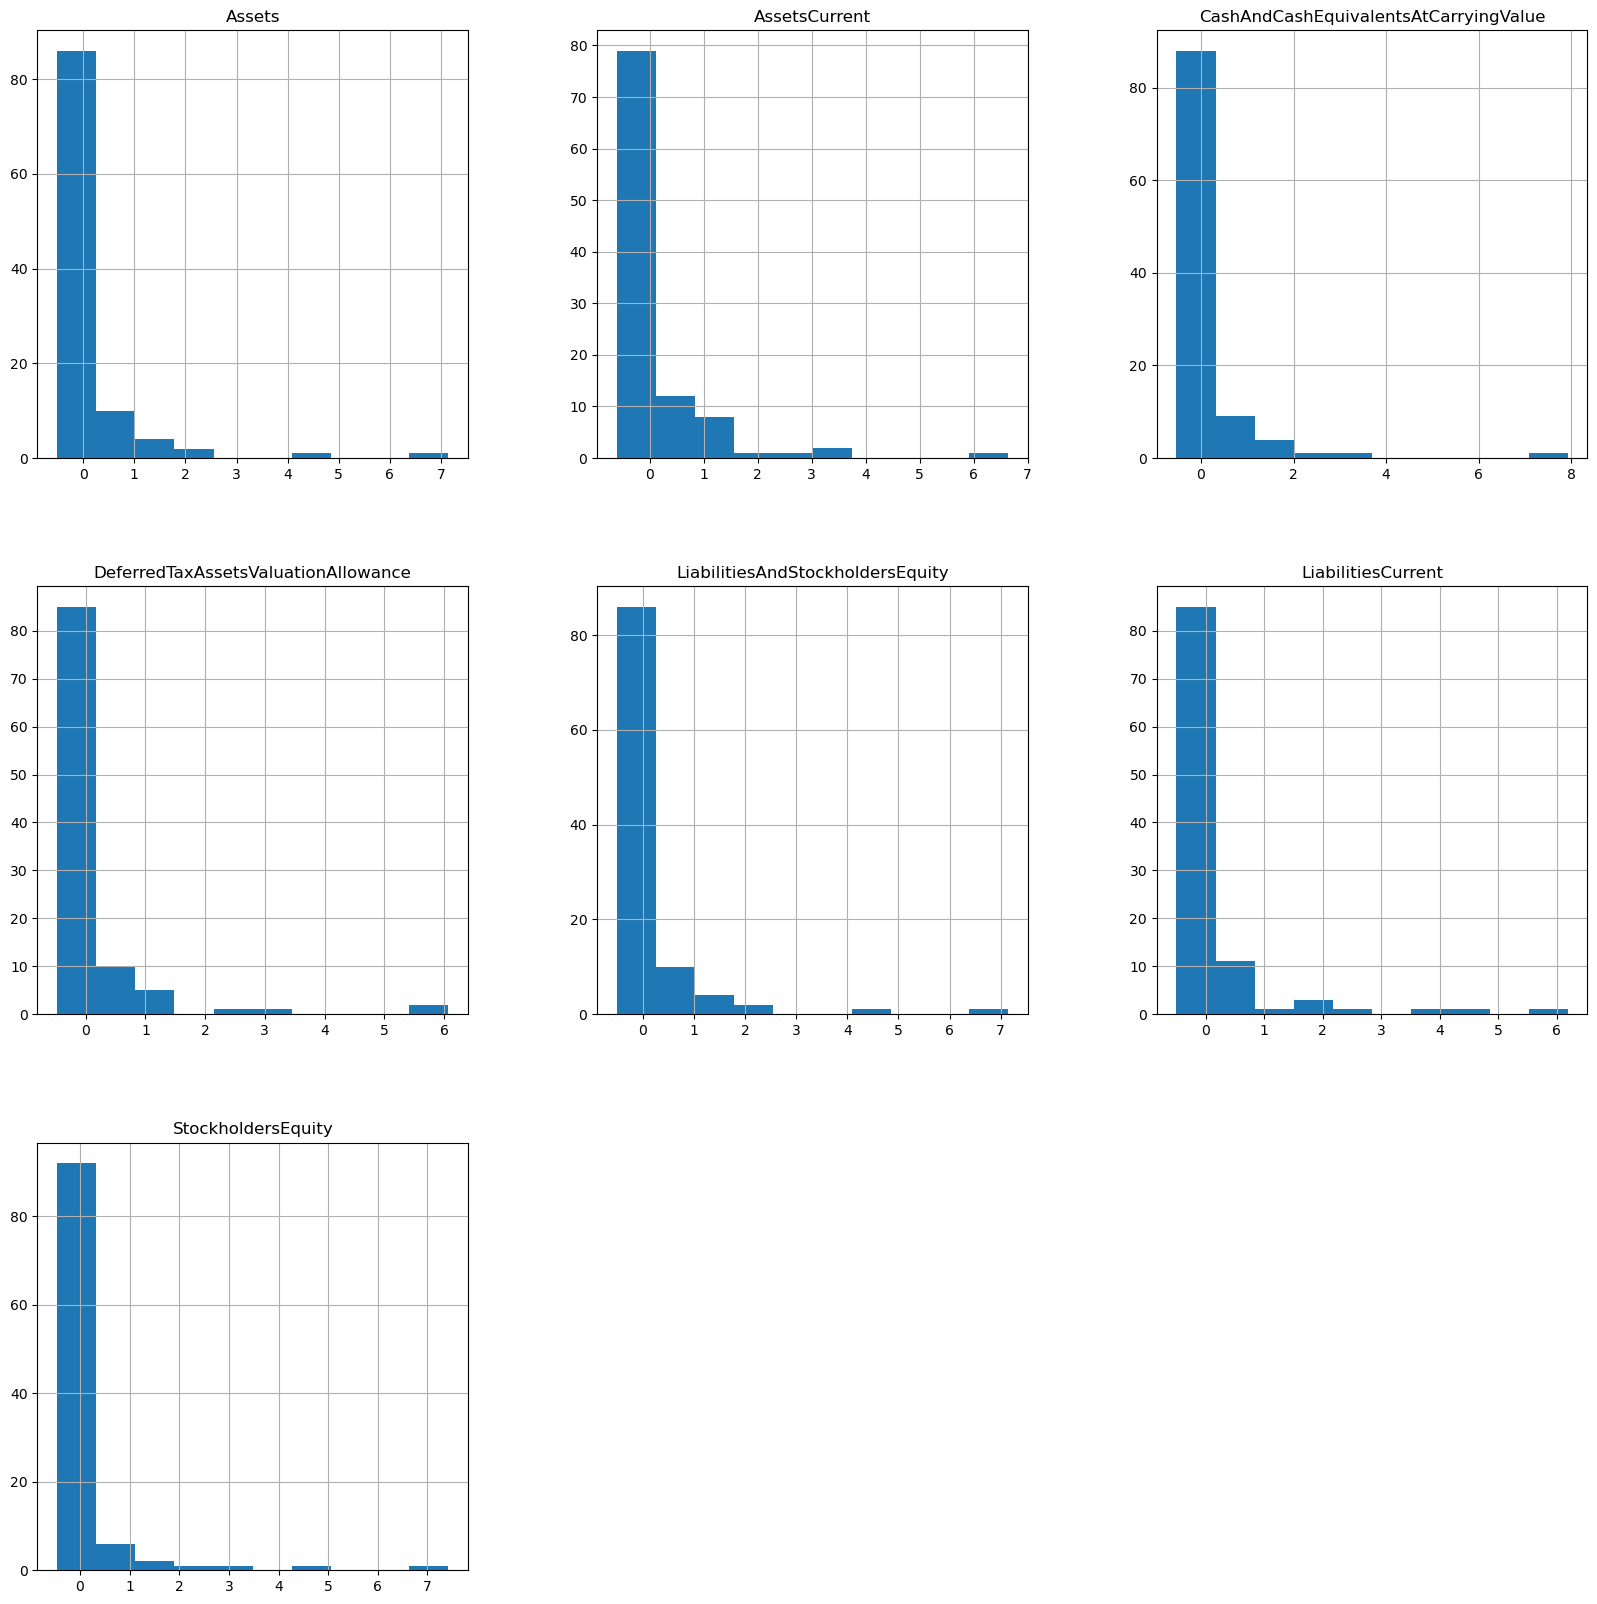

In [8]:
from sklearn.preprocessing import StandardScaler

# Standard scale features to have mean 0 and variance 1
sc = StandardScaler()
df_table.iloc[:, 1:] = sc.fit_transform(df_table.iloc[:, 1:])

# Visualize distribution of all fields
df_table.iloc[:, 1:].hist(figsize=(20, 20))

array([[<AxesSubplot:title={'center':'Assets'}>,
        <AxesSubplot:title={'center':'AssetsCurrent'}>,
        <AxesSubplot:title={'center':'CashAndCashEquivalentsAtCarryingValue'}>],
       [<AxesSubplot:title={'center':'DeferredTaxAssetsValuationAllowance'}>,
        <AxesSubplot:title={'center':'LiabilitiesAndStockholdersEquity'}>,
        <AxesSubplot:title={'center':'LiabilitiesCurrent'}>],
       [<AxesSubplot:title={'center':'StockholdersEquity'}>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

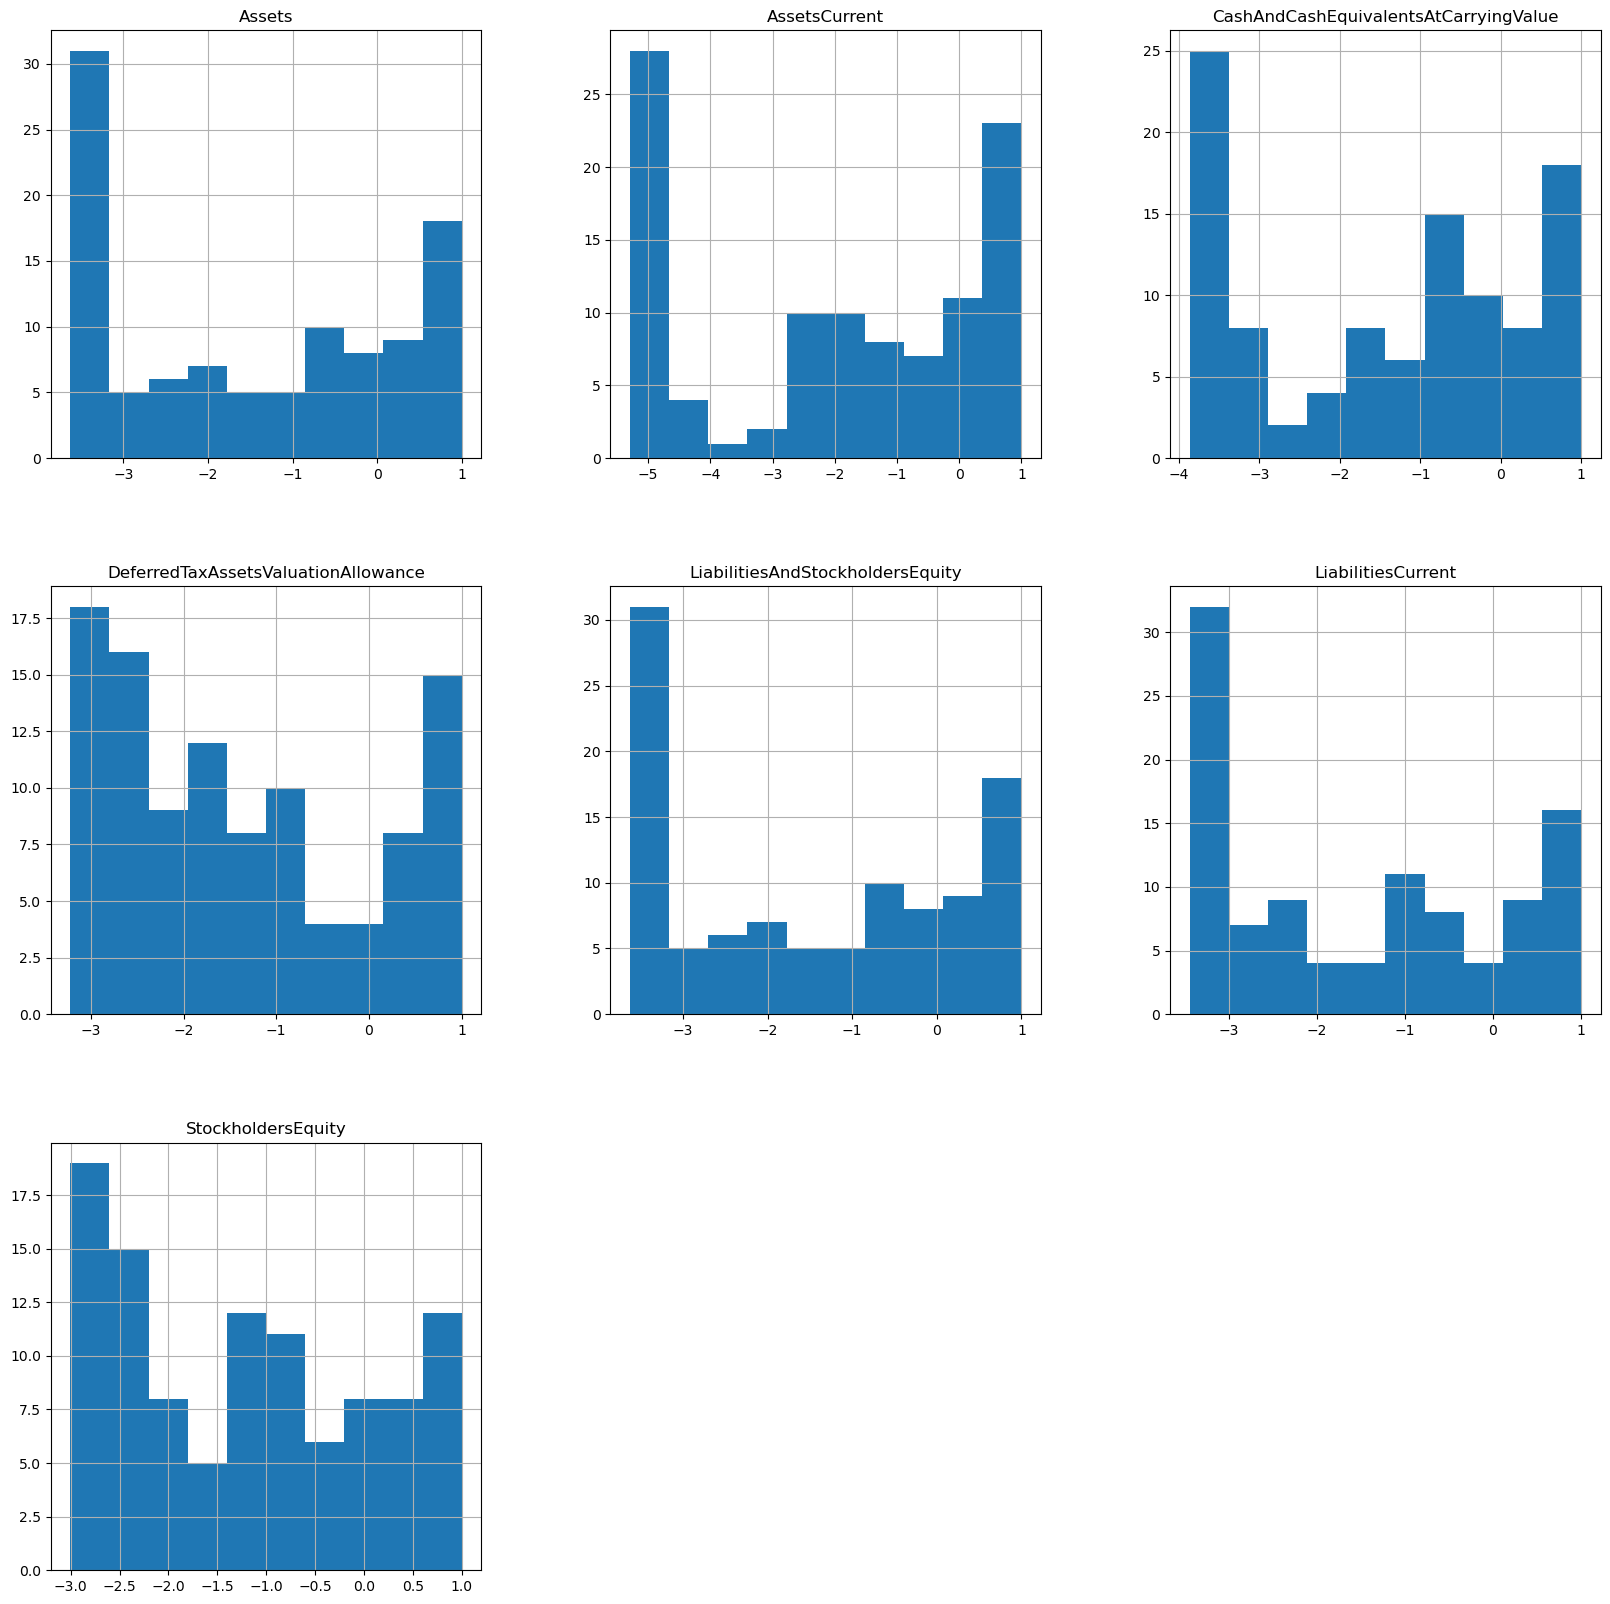

In [9]:
# We want to log normalize all the columns but some are negative or zero so this fails.
# Thus we can subtract the min (so each feature's new min is 0) and then add a tiny constant to make it always positive
#df_table.iloc[:, 1:] = np.log(df_table.iloc[:, 1:] - df_table.iloc[:, 1:].min(axis=0) + 100)

# 1 - exp(-3x)
df_table.iloc[:, 1:] = 1 - np.exp(-3*df_table.iloc[:, 1:])


# Visualize distribution of all fields
df_table.iloc[:, 1:].hist(figsize=(20, 20))

In [10]:
##########
# Join df_text and df_table on CIK

df_joined = df_text_non_tokenized.join(df_table.set_index("CIK"), on="cik", how="inner").reset_index()
df_joined = df_joined.drop(["index", "level_0"], axis=1)
print(df_joined.shape)

df_joined.head()

(104, 40)


,cik,company,filing_type,filing_date,period_of_report,sic,state_of_inc,state_location,fiscal_year_end,filing_html_index,...,item_13,item_14,item_15,Assets,AssetsCurrent,CashAndCashEquivalentsAtCarryingValue,DeferredTaxAssetsValuationAllowance,LiabilitiesAndStockholdersEquity,LiabilitiesCurrent,StockholdersEquity
0,1001601,"MGT CAPITAL INVESTMENTS, INC.",10-K,2021-04-15,2020-12-31,7374,DE,NC,1231,https://www.sec.gov/Archives/edgar/data/100160...,...,item certain relationship related transaction ...,item principal accountant fee service effectiv...,item exhibit financial statement schedule fina...,-3.616447,-5.287871,-3.858846,-1.805067,-3.616447,-3.414389,-2.669813
1,1013462,ANSYS INC,10-K,2021-02-24,2020-12-31,7372,DE,PA,1231,https://www.sec.gov/Archives/edgar/data/101346...,...,item certain relationship related transaction ...,item principal accountant fee service informat...,item exhibit financial statement schedule docu...,0.983216,0.936303,0.972254,-2.293422,0.983216,0.686885,0.997474
2,1013857,PEGASYSTEMS INC,10-K,2021-02-17,2020-12-31,7374,MA,MA,1231,https://www.sec.gov/Archives/edgar/data/101385...,...,item certain relationship related transaction ...,item principal accountant fee service informat...,item exhibit financial statement schedule foll...,-0.014454,0.537222,-0.838562,-1.894527,-0.014454,0.167482,-0.401478
3,1015739,AWARE INC /MA/,10-K,2021-02-17,2020-12-31,7372,MA,MA,1231,https://www.sec.gov/Archives/edgar/data/101573...,...,item certain relationship related transaction ...,item principal accountant fee service informat...,item exhibit financial statement schedule foll...,-3.406001,-4.599352,-2.911078,-2.670366,-3.406001,-3.349150,-2.386692
4,1017655,PAID INC,10-K,2021-03-31,2020-12-31,7389,DE,MA,1231,https://www.sec.gov/Archives/edgar/data/101765...,...,item certain relationship related transaction ...,item principal accountant fee service kmj corb...,item exhibit financial statement schedule fina...,-3.601249,-5.258537,-3.820265,-2.570315,-3.601249,-3.414313,-2.653599


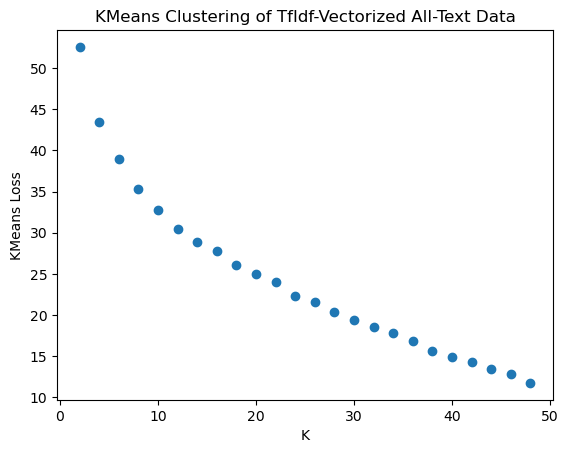

In [11]:
#########
# Preprocess df_text

from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation

# Concatenate all text fields and then vectorize the whole thing
df_joined["all_text"] = df_joined.loc[:, text_columns].sum(axis=1)

# Vectorize this concatenated string
# vec = CountVectorizer(max_df=0.95, binary=True)
vec = TfidfVectorizer(max_df=0.95, max_features=50)
X_text = vec.fit_transform(df_joined["all_text"])

#########
# Cluster X_text
losses = {}
losses_agg = {}

# cluster on text ONLY
for k in range(2, 50, 2):
    km = KMeans(n_clusters=k, random_state=1).fit(X_text)
    labels_txt_km = km.predict(X_text)
    losses[k] = km.inertia_

plt.scatter(losses.keys(), losses.values())
plt.title("KMeans Clustering of TfIdf-Vectorized All-Text Data")
plt.xlabel("K")
plt.ylabel("KMeans Loss")

# Inspect the text clusters by printing CIKs
OPTIMAL_K = 10
km = KMeans(n_clusters=OPTIMAL_K, random_state=1).fit(X_text)
labels_txt_km = km.predict(X_text)

cluster_ciks = defaultdict(list)
km_cluster_companies_text = defaultdict(list)
for row, label in enumerate(labels_txt_km):
    cluster_ciks[label].append(df_joined["cik"][row])

#print([len(cluster) for cluster in cluster_ciks.values()], cluster_ciks)

for label in cluster_ciks:
    #print("Label", label)
    #print(df_joined.set_index("cik").loc[cluster_ciks[label], "company"])
    km_cluster_companies_text[label] = df_joined.set_index("cik").loc[cluster_ciks[label], "company"]

#print(cluster_companies_text)


In [12]:
# Now try agglomerative clustering on text
agg = AgglomerativeClustering(n_clusters=OPTIMAL_K).fit(X_text.toarray())
labels_txt_agg = agg.labels_

agg_cluster_ciks = defaultdict(list)
agg_cluster_companies_text = defaultdict(list)
for row, label in enumerate(labels_txt_agg):
    agg_cluster_ciks[label].append(df_joined["cik"][row])

for label in agg_cluster_ciks:
    agg_cluster_companies_text[label] = df_joined.set_index("cik").loc[agg_cluster_ciks[label], "company"]

print([len(x) for x in agg_cluster_companies_text.values()])
print(agg_cluster_companies_text)

[10, 13, 7, 28, 5, 3, 19, 10, 5, 4]
defaultdict(<class 'list'>, {3: cik
1001601    MGT CAPITAL INVESTMENTS, INC.
1019034        BIO KEY INTERNATIONAL INC
1081745              INTELLINETICS, INC.
1084384                    PARETEUM Corp
1167419            Riot Blockchain, Inc.
1353499                   Max Sound Corp
1389067                 TAUTACHROME INC.
1567771         BRIDGEWAY NATIONAL CORP.
1567900              BLACKBOXSTOCKS INC.
837852                  IDEANOMICS, INC.
Name: company, dtype: object, 2: cik
1013462                     ANSYS INC
1031308           BENTLEY SYSTEMS INC
1044777                  OneSpan Inc.
1052054          EVOLVING SYSTEMS INC
1064722              GIVEMEPOWER CORP
1467761        Zoom Telephonics, Inc.
1505155         Upland Software, Inc.
320340       INTELLIGENT SYSTEMS CORP
736012                  INTRUSION INC
876167     PROGRESS SOFTWARE CORP /MA
877890             CITRIX SYSTEMS INC
935036            ACI WORLDWIDE, INC.
944480                GSE

In [13]:
# Now try affinitypropagation clustering on text
aff = AffinityPropagation(random_state=1).fit(X_text.toarray())
labels_txt_aff = aff.labels_

aff_cluster_ciks = defaultdict(list)
aff_cluster_companies_text = defaultdict(list)
for row, label in enumerate(labels_txt_aff):
    aff_cluster_ciks[label].append(df_joined["cik"][row])

for label in aff_cluster_ciks:
    aff_cluster_companies_text[label] = df_joined.set_index("cik").loc[aff_cluster_ciks[label], "company"]

print([len(x) for x in aff_cluster_companies_text.values()])
print(aff_cluster_companies_text)

[15, 8, 8, 19, 3, 4, 10, 10, 7, 10, 1, 4, 5]
defaultdict(<class 'list'>, {9: cik
1001601    MGT CAPITAL INVESTMENTS, INC.
1017655                         PAID INC
1019034        BIO KEY INTERNATIONAL INC
1081745              INTELLINETICS, INC.
1084384                    PARETEUM Corp
1084577                       CYREN Ltd.
1167419            Riot Blockchain, Inc.
1337619                  ENVESTNET, INC.
1353499                   Max Sound Corp
1389067                 TAUTACHROME INC.
1567771         BRIDGEWAY NATIONAL CORP.
1567900              BLACKBOXSTOCKS INC.
1624512                    Boxlight Corp
1682325     GTY Technology Holdings Inc.
837852                  IDEANOMICS, INC.
Name: company, dtype: object, 10: cik
1013462                     ANSYS INC
1044777                  OneSpan Inc.
1467761        Zoom Telephonics, Inc.
1739936                     SVMK Inc.
320340       INTELLIGENT SYSTEMS CORP
736012                  INTRUSION INC
814549                       EBIX INC


In [14]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=OPTIMAL_K, random_state=0).fit(X_text.toarray())
labels_txt_gm = gm.predict(X_text.toarray())

gm_cluster_ciks = defaultdict(list)
gm_cluster_companies_text = defaultdict(list)
for row, label in enumerate(labels_txt_gm):
    gm_cluster_ciks[label].append(df_joined["cik"][row])

for label in gm_cluster_ciks:
    gm_cluster_companies_text[label] = df_joined.set_index("cik").loc[gm_cluster_ciks[label], "company"]

print([len(x) for x in gm_cluster_companies_text.values()])
print(gm_cluster_companies_text)

[8, 14, 9, 11, 5, 11, 11, 5, 10, 20]
defaultdict(<class 'list'>, {8: cik
1001601    MGT CAPITAL INVESTMENTS, INC.
1019034        BIO KEY INTERNATIONAL INC
1021435                       hopTo Inc.
1081745              INTELLINETICS, INC.
1353499                   Max Sound Corp
1567771         BRIDGEWAY NATIONAL CORP.
1567900              BLACKBOXSTOCKS INC.
837852                  IDEANOMICS, INC.
Name: company, dtype: object, 5: cik
1013462                     ANSYS INC
1031308           BENTLEY SYSTEMS INC
1044777                  OneSpan Inc.
1052054          EVOLVING SYSTEMS INC
1064722              GIVEMEPOWER CORP
1389002            MARIN SOFTWARE INC
1467761        Zoom Telephonics, Inc.
1505155         Upland Software, Inc.
320340       INTELLIGENT SYSTEMS CORP
736012                  INTRUSION INC
876167     PROGRESS SOFTWARE CORP /MA
877890             CITRIX SYSTEMS INC
935036            ACI WORLDWIDE, INC.
944480                GSE SYSTEMS INC
Name: company, dtype: object, 

defaultdict(<class 'list'>, {8: cik
1001601              MGT CAPITAL INVESTMENTS, INC.
1046327                           REALNETWORKS INC
1054721                           BSQUARE CORP /WA
1084384                              PARETEUM Corp
1084577                                 CYREN Ltd.
1342936    Advanced Voice Recognition Systems, Inc
1351636                           SHOTSPOTTER, INC
1389002                         MARIN SOFTWARE INC
829323                                 Inuvo, Inc.
843006                          ISSUER DIRECT CORP
892482                                   Qumu Corp
922521                     FALCONSTOR SOFTWARE INC
941685                       IMAGEWARE SYSTEMS INC
948708                  SMITH MICRO SOFTWARE, INC.
Name: company, dtype: object, 6: cik
1013462                                ANSYS INC
1013857                          PEGASYSTEMS INC
1084048                          J2 GLOBAL, INC.
1280058                            BLACKBAUD INC
1337619          

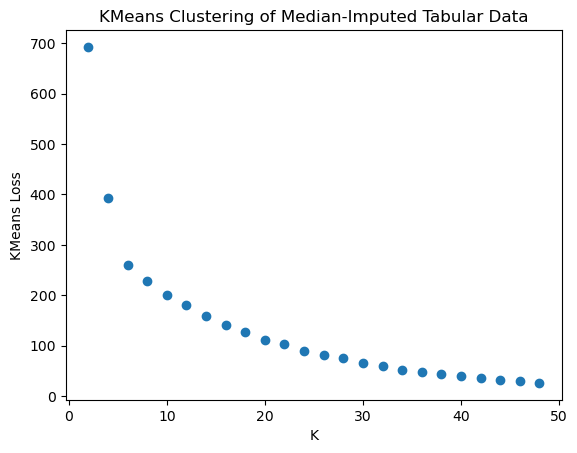

In [15]:
#######
# cluster on tabular/financials ONLY
X_table = df_joined[df_table.columns[1:]]

# use kmeans
losses = {}

for k in range(2, 50, 2):
    km = KMeans(n_clusters=k, random_state=1).fit(X_table)
    labels_tab_km = km.predict(X_table)
    losses[k] = km.inertia_

plt.scatter(losses.keys(), losses.values())
plt.title("KMeans Clustering of Median-Imputed Tabular Data")
plt.xlabel("K")
plt.ylabel("KMeans Loss")

# Inspect the tabular clusters by printing CIKs
OPTIMAL_K = 10
km = KMeans(n_clusters=OPTIMAL_K, random_state=1).fit(X_table)
labels_tab_km = km.predict(X_table)

cluster_ciks = defaultdict(list)
km_cluster_companies_table = defaultdict(list)
for row, label in enumerate(labels_tab_km):
    cluster_ciks[label].append(df_joined["cik"][row])

#print([len(cluster) for cluster in cluster_ciks.values()], cluster_ciks)

for label in cluster_ciks:
    #print("Label", label)
    #print(df_joined.set_index("cik").loc[cluster_ciks[label], "company"])
    km_cluster_companies_table[label] = df_joined.set_index("cik").loc[cluster_ciks[label], "company"]

print(km_cluster_companies_table)

In [16]:
# Now try agglomerative clustering on tabular
agg = AgglomerativeClustering(n_clusters=OPTIMAL_K).fit(X_table)
labels_tab_agg = agg.labels_

agg_cluster_ciks = defaultdict(list)
agg_cluster_companies_tab = defaultdict(list)
for row, label in enumerate(labels_tab_agg):
    agg_cluster_ciks[label].append(df_joined["cik"][row])

for label in agg_cluster_ciks:
    agg_cluster_companies_tab[label] = df_joined.set_index("cik").loc[agg_cluster_ciks[label], "company"]

print([len(x) for x in agg_cluster_companies_tab.values()])
print(agg_cluster_companies_tab)

[25, 6, 9, 10, 8, 8, 12, 8, 12, 6]
defaultdict(<class 'list'>, {3: cik
1001601              MGT CAPITAL INVESTMENTS, INC.
1015739                             AWARE INC /MA/
1017655                                   PAID INC
1019034                  BIO KEY INTERNATIONAL INC
1021435                                 hopTo Inc.
1052054                       EVOLVING SYSTEMS INC
1054721                           BSQUARE CORP /WA
1064722                           GIVEMEPOWER CORP
1081745                        INTELLINETICS, INC.
1342936    Advanced Voice Recognition Systems, Inc
1351636                           SHOTSPOTTER, INC
1353499                             Max Sound Corp
1362190                               AUDIOEYE INC
1389067                           TAUTACHROME INC.
1467761                     Zoom Telephonics, Inc.
1567771                   BRIDGEWAY NATIONAL CORP.
1624512                              Boxlight Corp
1682325               GTY Technology Holdings Inc.
320340     

In [17]:
gm = GaussianMixture(n_components=OPTIMAL_K, random_state=0).fit(X_table)
labels_tab_gm = gm.predict(X_table)

gm_cluster_ciks = defaultdict(list)
gm_cluster_companies_tab = defaultdict(list)
for row, label in enumerate(labels_tab_gm):
    gm_cluster_ciks[label].append(df_joined["cik"][row])

for label in gm_cluster_ciks:
    gm_cluster_companies_tab[label] = df_joined.set_index("cik").loc[gm_cluster_ciks[label], "company"]

print([len(x) for x in gm_cluster_companies_tab.values()])
print(gm_cluster_companies_tab)

[34, 8, 7, 8, 10, 7, 11, 13, 1, 5]
defaultdict(<class 'list'>, {1: cik
1001601              MGT CAPITAL INVESTMENTS, INC.
1015739                             AWARE INC /MA/
1017655                                   PAID INC
1019034                  BIO KEY INTERNATIONAL INC
1021435                                 hopTo Inc.
1046327                           REALNETWORKS INC
1052054                       EVOLVING SYSTEMS INC
1054721                           BSQUARE CORP /WA
1064722                           GIVEMEPOWER CORP
1081745                        INTELLINETICS, INC.
1084384                              PARETEUM Corp
1084577                                 CYREN Ltd.
1169652                        CHANNELADVISOR CORP
1342936    Advanced Voice Recognition Systems, Inc
1351636                           SHOTSPOTTER, INC
1353499                             Max Sound Corp
1362190                               AUDIOEYE INC
1389002                         MARIN SOFTWARE INC
1389067    

defaultdict(<class 'list'>, {7: cik
1001601              MGT CAPITAL INVESTMENTS, INC.
1015739                             AWARE INC /MA/
1017655                                   PAID INC
1019034                  BIO KEY INTERNATIONAL INC
1021435                                 hopTo Inc.
1052054                       EVOLVING SYSTEMS INC
1054721                           BSQUARE CORP /WA
1064722                           GIVEMEPOWER CORP
1081745                        INTELLINETICS, INC.
1342936    Advanced Voice Recognition Systems, Inc
1351636                           SHOTSPOTTER, INC
1353499                             Max Sound Corp
1362190                               AUDIOEYE INC
1389067                           TAUTACHROME INC.
1467761                     Zoom Telephonics, Inc.
1567771                   BRIDGEWAY NATIONAL CORP.
1624512                              Boxlight Corp
1682325               GTY Technology Holdings Inc.
320340                    INTELLIGENT SYSTEMS 

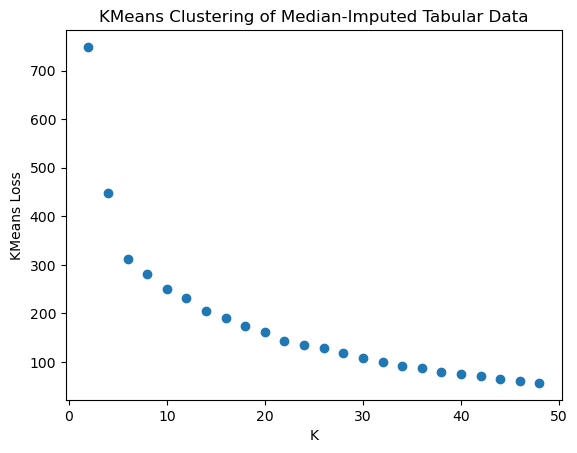

In [18]:
from scipy.sparse import hstack

#######
# cluster on tabular AND text
X_both = hstack((X_table, X_text))

# use kmeans
losses = {}

for k in range(2, 50, 2):
    km = KMeans(n_clusters=k, random_state=1).fit(X_both)
    labels_both_km = km.predict(X_both)
    losses[k] = km.inertia_

plt.scatter(losses.keys(), losses.values())
plt.title("KMeans Clustering of Median-Imputed Tabular Data")
plt.xlabel("K")
plt.ylabel("KMeans Loss")

# Inspect the tabular clusters by printing CIKs
OPTIMAL_K = 10
km = KMeans(n_clusters=OPTIMAL_K, random_state=1).fit(X_both)
labels_both_km = km.predict(X_both)

cluster_ciks = defaultdict(list)
km_cluster_companies_both = defaultdict(list)
for row, label in enumerate(labels_both_km):
    cluster_ciks[label].append(df_joined["cik"][row])

#print([len(cluster) for cluster in cluster_ciks.values()], cluster_ciks)

for label in cluster_ciks:
    #print("Label", label)
    #print(df_joined.set_index("cik").loc[cluster_ciks[label], "company"])
    km_cluster_companies_both[label] = df_joined.set_index("cik").loc[cluster_ciks[label], "company"]

print(km_cluster_companies_both)

In [19]:
# Now try agglomerative clustering on both
agg = AgglomerativeClustering(n_clusters=OPTIMAL_K).fit(X_both.toarray())
labels_both_agg = agg.labels_

agg_cluster_ciks = defaultdict(list)
agg_cluster_companies_both = defaultdict(list)
for row, label in enumerate(labels_both_agg):
    agg_cluster_ciks[label].append(df_joined["cik"][row])

for label in agg_cluster_ciks:
    agg_cluster_companies_both[label] = df_joined.set_index("cik").loc[agg_cluster_ciks[label], "company"]

print([len(x) for x in agg_cluster_companies_both.values()])
print(agg_cluster_companies_both)

[31, 6, 9, 10, 8, 11, 9, 13, 5, 2]
defaultdict(<class 'list'>, {1: cik
1001601              MGT CAPITAL INVESTMENTS, INC.
1015739                             AWARE INC /MA/
1017655                                   PAID INC
1019034                  BIO KEY INTERNATIONAL INC
1021435                                 hopTo Inc.
1046327                           REALNETWORKS INC
1052054                       EVOLVING SYSTEMS INC
1054721                           BSQUARE CORP /WA
1064722                           GIVEMEPOWER CORP
1081745                        INTELLINETICS, INC.
1084384                              PARETEUM Corp
1084577                                 CYREN Ltd.
1342936    Advanced Voice Recognition Systems, Inc
1351636                           SHOTSPOTTER, INC
1353499                             Max Sound Corp
1362190                               AUDIOEYE INC
1389002                         MARIN SOFTWARE INC
1389067                           TAUTACHROME INC.
1467761    

In [20]:
gm = GaussianMixture(n_components=OPTIMAL_K, random_state=0).fit(X_both.toarray())
labels_both_gm = gm.predict(X_both.toarray())

gm_cluster_ciks = defaultdict(list)
gm_cluster_companies_both = defaultdict(list)
for row, label in enumerate(labels_both_gm):
    gm_cluster_ciks[label].append(df_joined["cik"][row])

for label in gm_cluster_ciks:
    gm_cluster_companies_both[label] = df_joined.set_index("cik").loc[gm_cluster_ciks[label], "company"]

print([len(x) for x in gm_cluster_companies_both.values()])
print(gm_cluster_companies_both)

[23, 12, 7, 5, 10, 5, 7, 8, 16, 11]
defaultdict(<class 'list'>, {9: cik
1001601    MGT CAPITAL INVESTMENTS, INC.
1015739                   AWARE INC /MA/
1017655                         PAID INC
1019034        BIO KEY INTERNATIONAL INC
1021435                       hopTo Inc.
1052054             EVOLVING SYSTEMS INC
1054721                 BSQUARE CORP /WA
1064722                 GIVEMEPOWER CORP
1081745              INTELLINETICS, INC.
1351636                 SHOTSPOTTER, INC
1353499                   Max Sound Corp
1362190                     AUDIOEYE INC
1389067                 TAUTACHROME INC.
1467761           Zoom Telephonics, Inc.
1567771         BRIDGEWAY NATIONAL CORP.
1624512                    Boxlight Corp
1682325     GTY Technology Holdings Inc.
320340          INTELLIGENT SYSTEMS CORP
736012                     INTRUSION INC
892482                         Qumu Corp
922521           FALCONSTOR SOFTWARE INC
941685             IMAGEWARE SYSTEMS INC
944480                   G

In [21]:
from sklearn.metrics import silhouette_score

print("KMEANS Labels")
print(silhouette_score(X_text, labels_txt_km))
print(silhouette_score(X_table, labels_tab_km))
print(silhouette_score(X_both, labels_both_km))

print("AgglomerativeClustering Labels")
print(silhouette_score(X_text, labels_txt_agg))
print(silhouette_score(X_table, labels_tab_agg))
print(silhouette_score(X_table, labels_both_agg))

print("GMM Labels")
print(silhouette_score(X_text, labels_txt_gm))
print(silhouette_score(X_table, labels_tab_gm))
print(silhouette_score(X_both, labels_both_gm))


KMEANS Labels
0.13796376573984961
0.3084673194185171
0.2344607528161631
AgglomerativeClustering Labels
0.14060119389023282
0.2784350157850304
0.34028751796601675
GMM Labels
0.10778857484950198
0.36208922387461634
0.2254135608473509


In [22]:
# Picked GMM
labels_tab, labels_txt, labels_both = labels_tab_agg, labels_txt_agg, labels_both_agg

In [23]:
# Compare similarity of clusterings on TEXT ONLY and TABULAR ONLY
from sklearn.metrics.cluster import adjusted_rand_score, adjusted_mutual_info_score

print("KMEANS")
print("TAB vs TXT")
print("Adj Rand score:", adjusted_rand_score(labels_tab_km, labels_txt_km))
print("Adj mutual info score:", adjusted_mutual_info_score(labels_tab_km, labels_txt_km))

print("BOTH vs TXT")
print("Adj Rand score:", adjusted_rand_score(labels_both_km, labels_txt_km))
print("Adj mutual info score:", adjusted_mutual_info_score(labels_both_km, labels_txt_km))

print("BOTH vs TAB")
print("Adj Rand score:", adjusted_rand_score(labels_both_km, labels_tab_km))
print("Adj mutual info score:", adjusted_mutual_info_score(labels_both_km, labels_tab_km))

print("GMM")
print("TAB vs TXT")
print("Adj Rand score:", adjusted_rand_score(labels_tab_gm, labels_txt_gm))
print("Adj mutual info score:", adjusted_mutual_info_score(labels_tab_gm, labels_txt_gm))

print("BOTH vs TXT")
print("Adj Rand score:", adjusted_rand_score(labels_both_gm, labels_txt_gm))
print("Adj mutual info score:", adjusted_mutual_info_score(labels_both_gm, labels_txt_gm))

print("BOTH vs TAB")
print("Adj Rand score:", adjusted_rand_score(labels_both_gm, labels_tab_gm))
print("Adj mutual info score:", adjusted_mutual_info_score(labels_both_gm, labels_tab_gm))

print("AGGLOMERATIVE")
print("TAB vs TXT")
print("Adj Rand score:", adjusted_rand_score(labels_tab_agg, labels_txt_agg))
print("Adj mutual info score:", adjusted_mutual_info_score(labels_tab_agg, labels_txt_agg))

print("BOTH vs TXT")
print("Adj Rand score:", adjusted_rand_score(labels_both_agg, labels_txt_agg))
print("Adj mutual info score:", adjusted_mutual_info_score(labels_both_agg, labels_txt_agg))

print("BOTH vs TAB")
print("Adj Rand score:", adjusted_rand_score(labels_both_agg, labels_tab_agg))
print("Adj mutual info score:", adjusted_mutual_info_score(labels_both_agg, labels_tab_agg))

KMEANS
TAB vs TXT
Adj Rand score: 0.0969207482016067
Adj mutual info score: 0.16970660918638528
BOTH vs TXT
Adj Rand score: 0.09265679079548977
Adj mutual info score: 0.17300801677711164
BOTH vs TAB
Adj Rand score: 0.6701090003712724
Adj mutual info score: 0.7702568868134696
GMM
TAB vs TXT
Adj Rand score: 0.048493401716484134
Adj mutual info score: 0.07847559653937938
BOTH vs TXT
Adj Rand score: 0.051401906703504495
Adj mutual info score: 0.08861351261418977
BOTH vs TAB
Adj Rand score: 0.595946742145022
Adj mutual info score: 0.6795123372222107
AGGLOMERATIVE
TAB vs TXT
Adj Rand score: 0.03493210643919559
Adj mutual info score: 0.10111159141338752
BOTH vs TXT
Adj Rand score: 0.03325278090354
Adj mutual info score: 0.10835764296876374
BOTH vs TAB
Adj Rand score: 0.8371649021519658
Adj mutual info score: 0.9087763994185828


c:\Users\jainr3\miniconda3\envs\ece5414\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


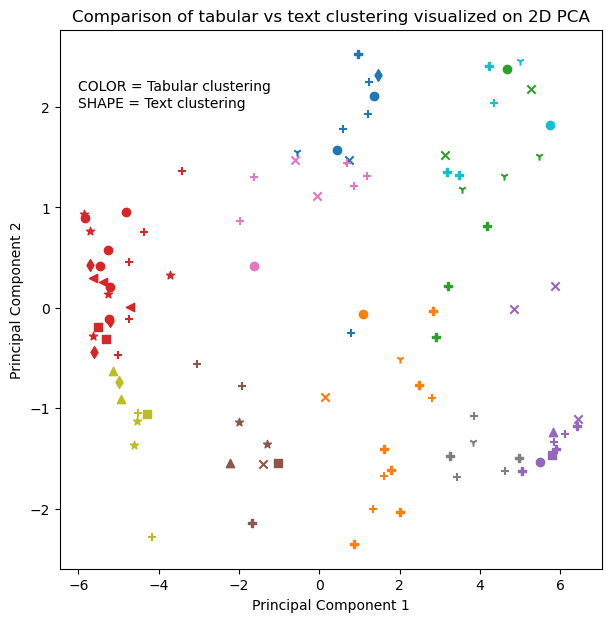

In [24]:
from sklearn.decomposition import PCA
import matplotlib.colors as mcolors

pca = PCA(n_components=2)
X_both_pca = pca.fit_transform(X_both.todense())

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot()

# map to colors
colors = {i:c for i, c in enumerate(list(mcolors.TABLEAU_COLORS)[:10])}
mapped_colors = []
  
for label in labels_tab:
  mapped_colors.append(colors[label])

# map to markers
markers = {0: "+", 1: "P", 2: "o", 3:"*", 4:"x", 5:"^", 6:"s", 7:"d", 8:"1", 9:"<"}
mapped_markers = []

for label in labels_txt:
  mapped_markers.append(markers[label])


for _s, c, _x, _y in zip(mapped_markers, mapped_colors, X_both_pca[:,0], X_both_pca[:,1]):
  ax.scatter(_x, _y, marker=_s, c=c)

#ax.scatter(X_both_pca[:,0], X_both_pca[:,1], c=labels_txt)
plt.text(-6, 2, "COLOR = Tabular clustering\nSHAPE = Text clustering")
plt.title("Comparison of tabular vs text clustering visualized on 2D PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

plt.show()


c:\Users\jainr3\miniconda3\envs\ece5414\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\jainr3\miniconda3\envs\ece5414\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\jainr3\miniconda3\envs\ece5414\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


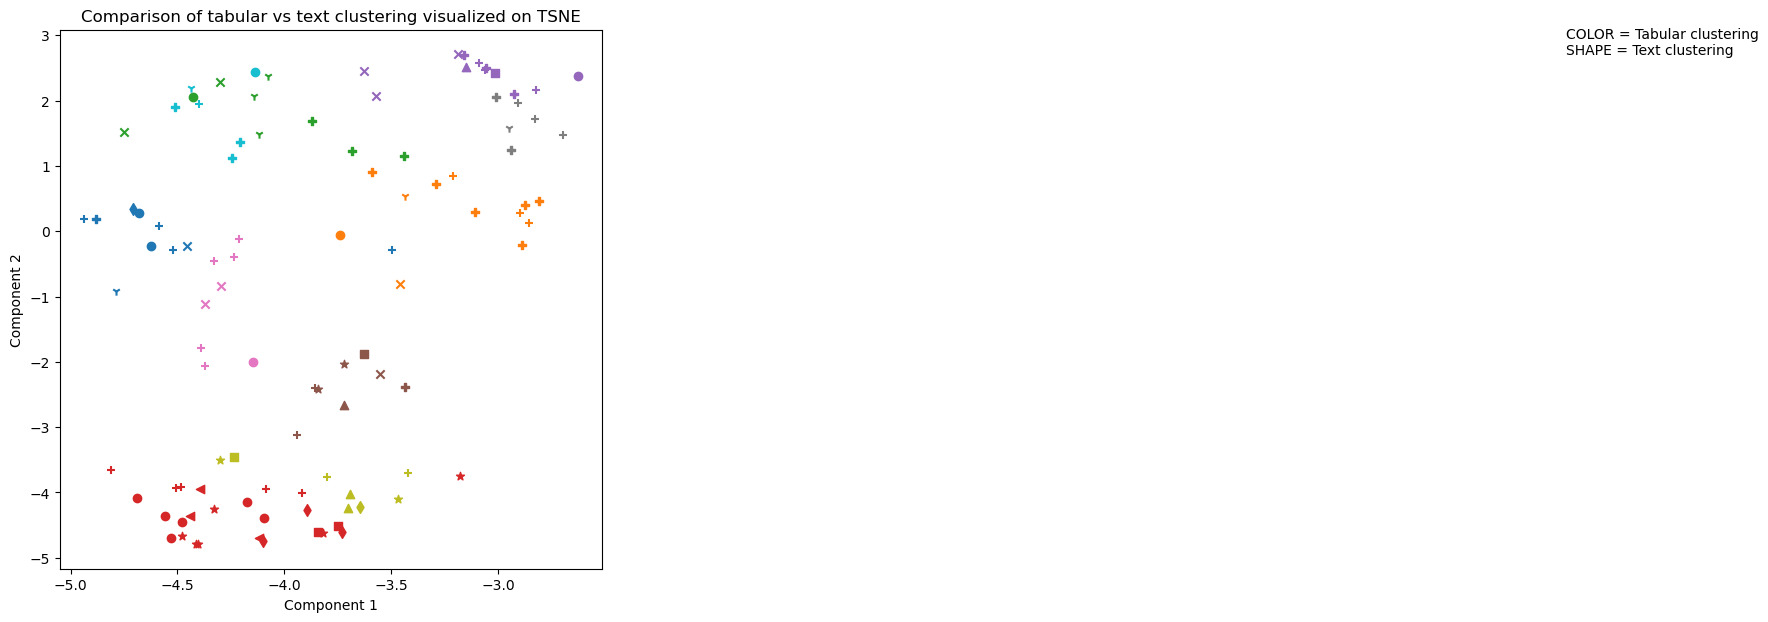

In [25]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=50, random_state=1)

X_both_tsne = tsne.fit_transform(X_both.todense())

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot()

# map to colors
colors = {i:c for i, c in enumerate(list(mcolors.TABLEAU_COLORS)[:10])}
mapped_colors = []
  
for label in labels_tab:
  mapped_colors.append(colors[label])

# map to markers
markers = {0: "+", 1: "P", 2: "o", 3:"*", 4:"x", 5:"^", 6:"s", 7:"d", 8:"1", 9:"<"}
mapped_markers = []

for label in labels_txt:
  mapped_markers.append(markers[label])


for _s, c, _x, _y in zip(mapped_markers, mapped_colors, X_both_tsne[:,0], X_both_tsne[:,1]):
  ax.scatter(_x, _y, marker=_s, c=c)

plt.text(2, 2.7, "COLOR = Tabular clustering\nSHAPE = Text clustering")
plt.title("Comparison of tabular vs text clustering visualized on TSNE")
plt.xlabel("Component 1")
plt.ylabel("Component 2")

plt.show()

c:\Users\jainr3\miniconda3\envs\ece5414\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


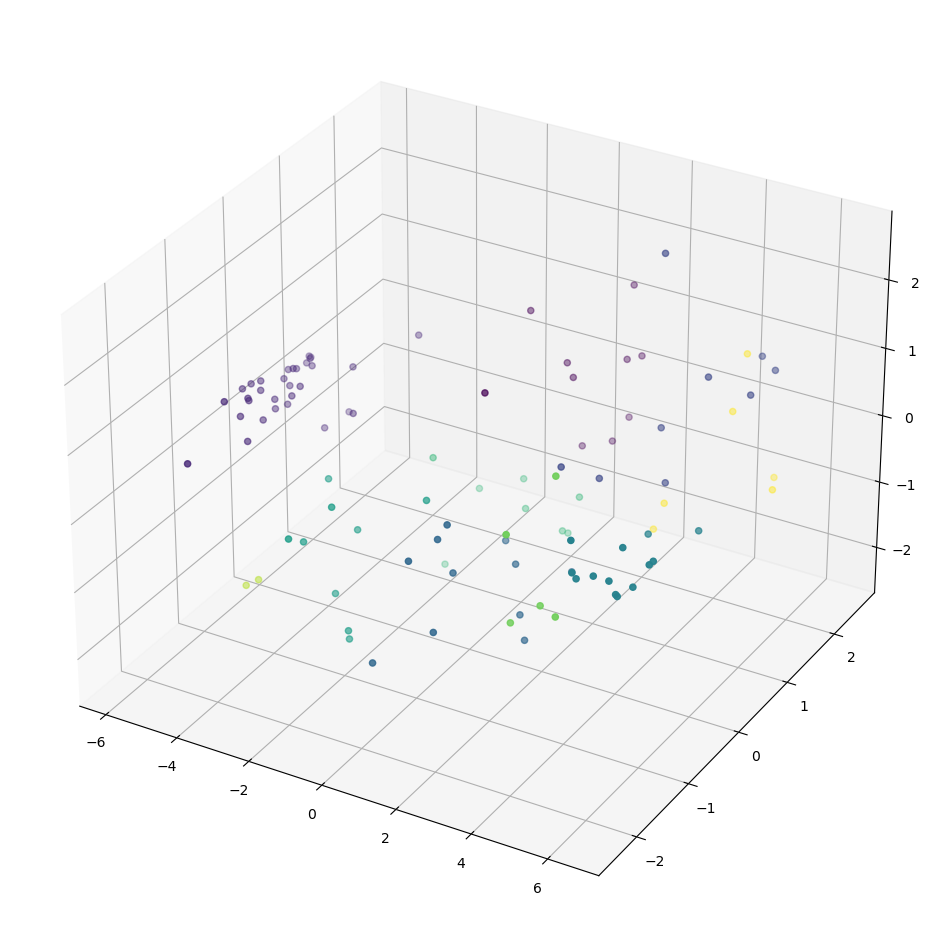

In [26]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
X_both_pca = pca.fit_transform(X_both.todense())

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

ax.scatter(X_both_pca[:,0], X_both_pca[:,1], X_both_pca[:,2], c=labels_both)

plt.show()

c:\Users\jainr3\miniconda3\envs\ece5414\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\jainr3\miniconda3\envs\ece5414\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\jainr3\miniconda3\envs\ece5414\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\jainr3\miniconda3\envs\ece5414\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy

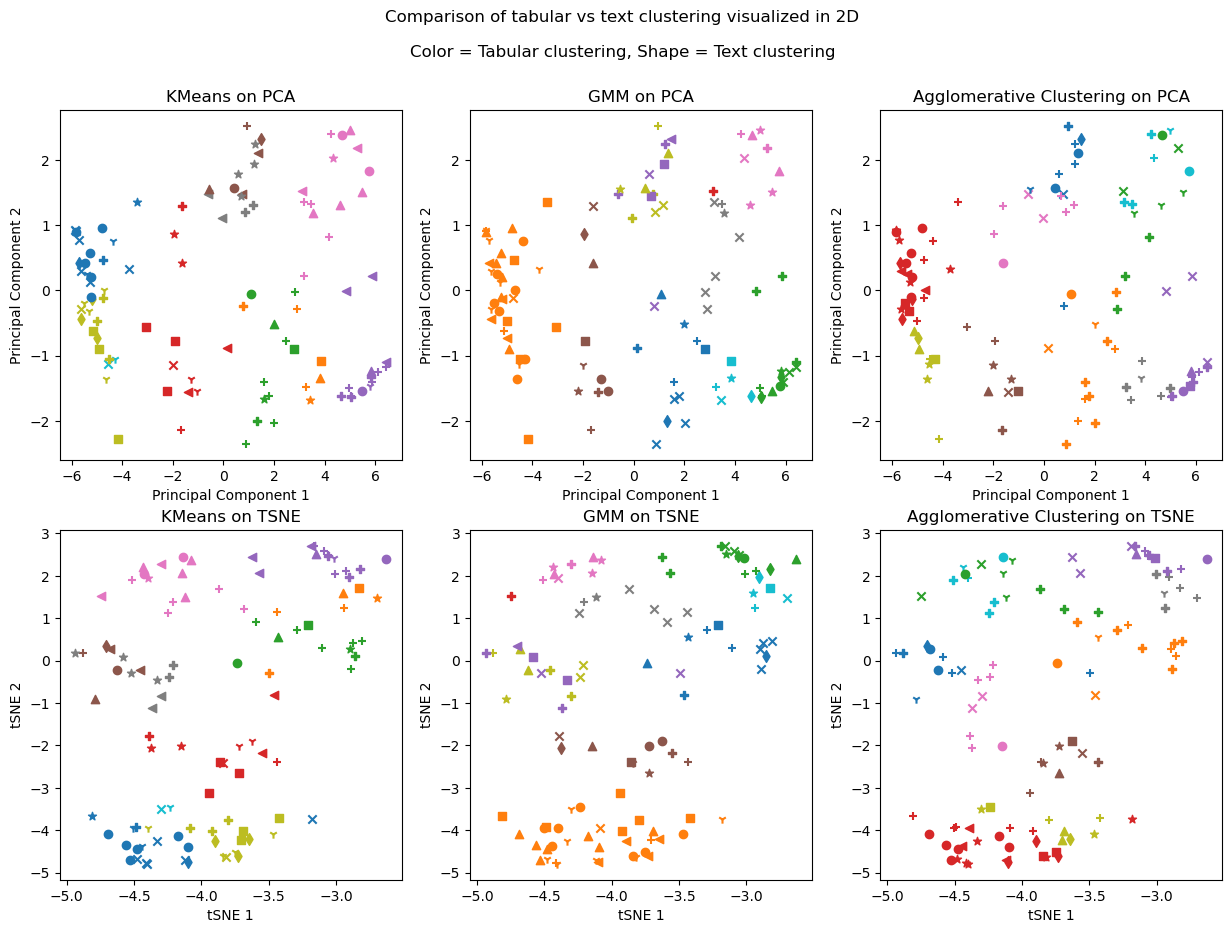

In [27]:
from sklearn.decomposition import PCA
import matplotlib.colors as mcolors



fig, ax = plt.subplots(2, 3, figsize=(15, 10))

for i, clust_labels in enumerate([
  (labels_tab_km, labels_txt_km),
  (labels_tab_gm, labels_txt_gm),
  (labels_tab_agg, labels_txt_agg)
]):
  for j, dim_reducer in enumerate([
    PCA(n_components=2, random_state=1),
    TSNE(n_components=2, perplexity=50, random_state=1)
  ]):
    
    X_both_dimred = dim_reducer.fit_transform(X_both.todense())
    if j == 0 and i == 0:  # Best setting in our opinion
      labels_tab_best = clust_labels[0]
      labels_txt_best = clust_labels[1]
      X_both_best = X_both_dimred
    
    # map to colors
    colors = {i: c for i, c in enumerate(list(mcolors.TABLEAU_COLORS)[:10])}
    mapped_colors = []

    for label in clust_labels[0]:
      mapped_colors.append(colors[label])

    # map to markers
    markers = {0: "+", 1: "P", 2: "o", 3: "*",
              4: "x", 5: "^", 6: "s", 7: "d", 8: "1", 9: "<"}
    mapped_markers = []

    for label in clust_labels[1]:
      mapped_markers.append(markers[label])

    for _s, c, _x, _y in zip(mapped_markers, mapped_colors, X_both_dimred[:, 0], X_both_dimred[:, 1]):
      ax[j, i].scatter(_x, _y, marker=_s, c=c)
      
      title = f'{["KMeans", "GMM", "Agglomerative Clustering"][i]} on {dim_reducer.__class__.__name__}'
      ax[j, i].set_title(title)
      
      if j == 0:
        ax[j, i].set_xlabel("Principal Component 1")
        ax[j, i].set_ylabel("Principal Component 2")
      elif j == 1:
        ax[j, i].set_xlabel("tSNE 1")
        ax[j, i].set_ylabel("tSNE 2")

fig.suptitle("Comparison of tabular vs text clustering visualized in 2D\n\nColor = Tabular clustering, Shape = Text clustering")
plt.show()

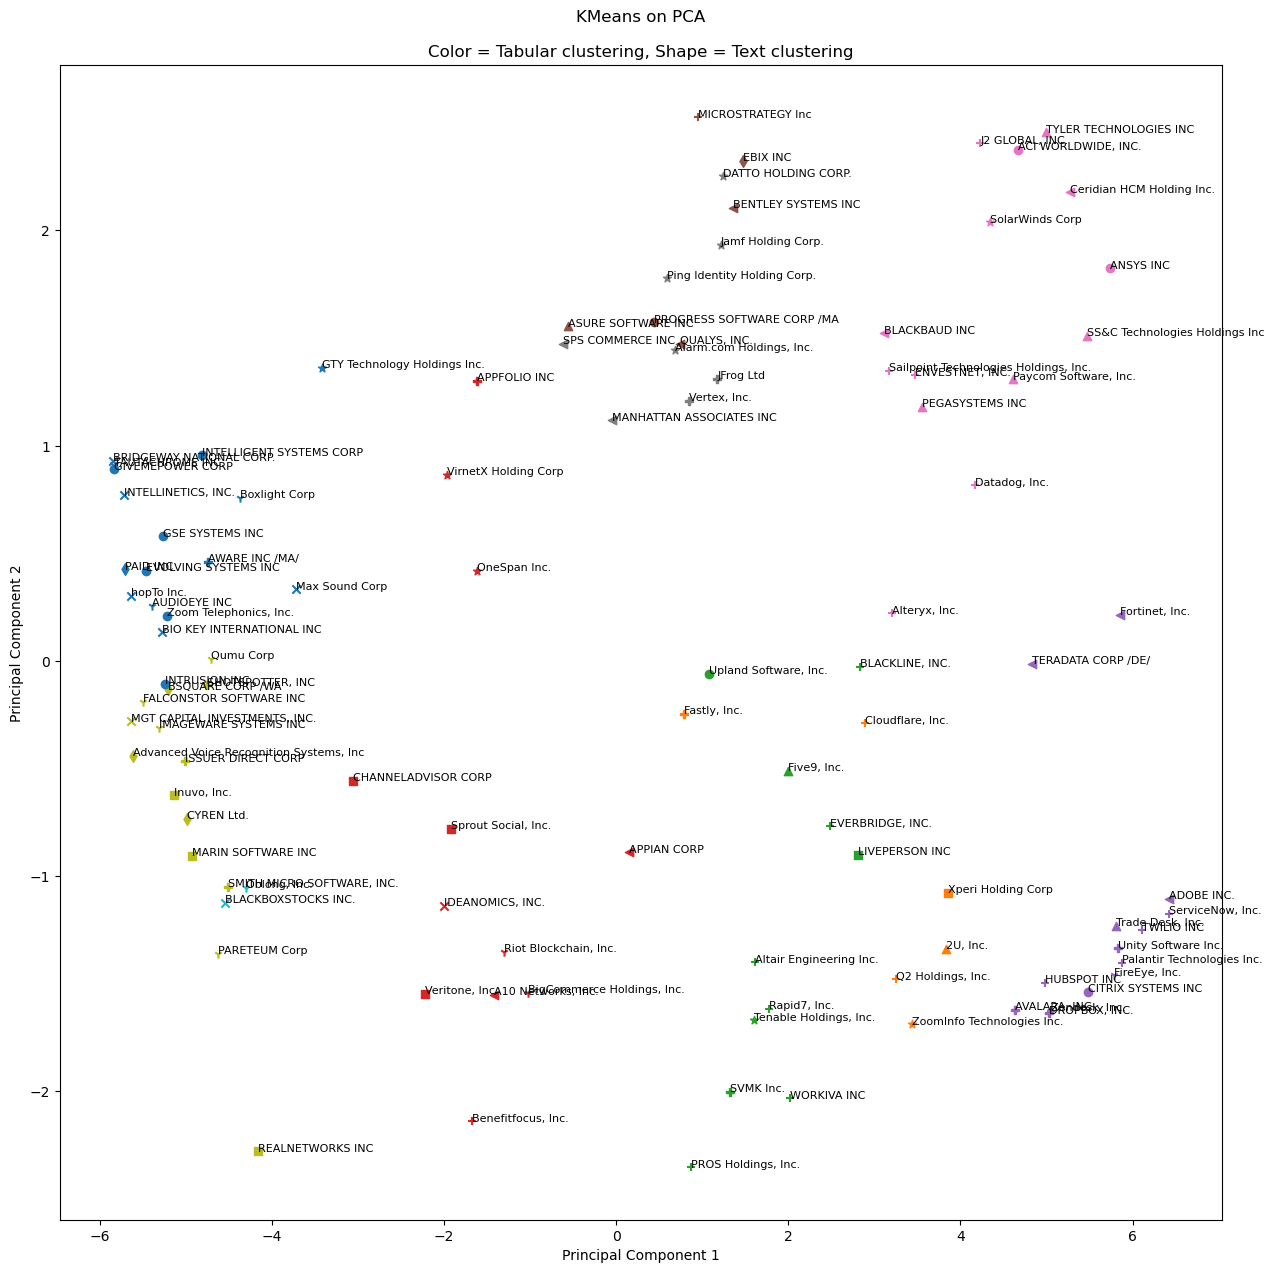

In [28]:
plt.figure(figsize=(15, 15))

# map to colors
colors = {i: c for i, c in enumerate(list(mcolors.TABLEAU_COLORS)[:10])}
mapped_colors = []

for label in labels_tab_best:
    mapped_colors.append(colors[label])

# map to markers
markers = {0: "+", 1: "P", 2: "o", 3: "*",
            4: "x", 5: "^", 6: "s", 7: "d", 8: "1", 9: "<"}
mapped_markers = []

for label in labels_txt_best:
    mapped_markers.append(markers[label])

for _s, c, _x, _y, i in zip(mapped_markers, mapped_colors, X_both_best[:, 0], X_both_best[:, 1], range(len(X_both_best))):
    plt.scatter(_x, _y, marker=_s, c=c)

    plt.title("KMeans on PCA\n\nColor = Tabular clustering, Shape = Text clustering")

    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    
    # if np.random.rand() <= 0.1:
    plt.text(_x, _y, df_joined['company'][i], fontsize=8)

In [29]:
km_cluster_companies_text

defaultdict(list,
            {4: cik
             1001601    MGT CAPITAL INVESTMENTS, INC.
             1019034        BIO KEY INTERNATIONAL INC
             1021435                       hopTo Inc.
             1081745              INTELLINETICS, INC.
             1353499                   Max Sound Corp
             1389067                 TAUTACHROME INC.
             1567771         BRIDGEWAY NATIONAL CORP.
             1567900              BLACKBOXSTOCKS INC.
             837852                  IDEANOMICS, INC.
             Name: company, dtype: object,
             2: cik
             1013462                     ANSYS INC
             1052054          EVOLVING SYSTEMS INC
             1064722              GIVEMEPOWER CORP
             1467761        Zoom Telephonics, Inc.
             1505155         Upland Software, Inc.
             320340       INTELLIGENT SYSTEMS CORP
             736012                  INTRUSION INC
             876167     PROGRESS SOFTWARE CORP /MA
     

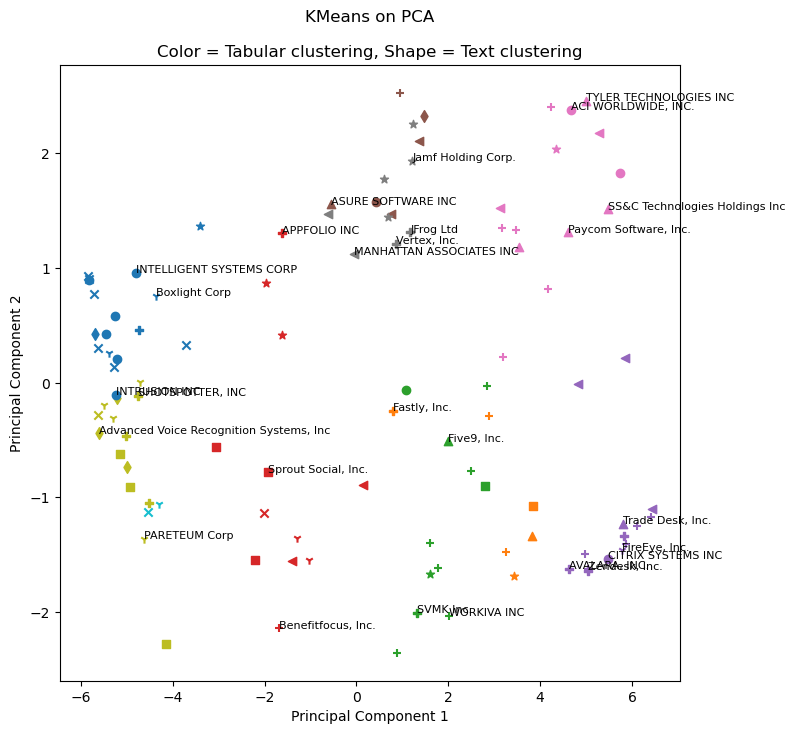

In [30]:
plt.figure(figsize=(8, 8))

# map to colors
colors = {i: c for i, c in enumerate(list(mcolors.TABLEAU_COLORS)[:10])}
mapped_colors = []

for label in labels_tab_best:
    mapped_colors.append(colors[label])

# map to markers
markers = {0: "+", 1: "P", 2: "o", 3: "*",
           4: "x", 5: "^", 6: "s", 7: "d", 8: "1", 9: "<"}
mapped_markers = []

for label in labels_txt_best:
    mapped_markers.append(markers[label])
    
HIGHLIGHTED_COMPANIES = [63, 55, 94, 78, 86, 83, 81, 100, 75, 40, 85, 27, 35, 61, 31, 13, 70, 96, 18, 43, 50, 46, 56, 30, 65, 97, 32]

for _s, c, _x, _y, i in zip(mapped_markers, mapped_colors, X_both_best[:, 0], X_both_best[:, 1], range(len(X_both_best))):
    plt.scatter(_x, _y, marker=_s, c=c)

    plt.title("KMeans on PCA\n\nColor = Tabular clustering, Shape = Text clustering")

    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")

    if i in HIGHLIGHTED_COMPANIES:
        plt.text(_x, _y, df_joined['company'][i], fontsize=8)


In [31]:
# rapid7, tenable, qumu, maxsound, jfrog, alarm.com, channeladvisor, bigcommerce, jamf, ping, paycom, ACI worldwide, envestment, sailpoint, abobe, palantir, citrix, dropbox, advanced voice recognition systems, audioeye, sps commerce, virnetx, cloudflare, fastly

# 

list(enumerate(df_joined['company']))

[(0, 'MGT CAPITAL INVESTMENTS, INC.'),
 (1, 'ANSYS INC'),
 (2, 'PEGASYSTEMS INC'),
 (3, 'AWARE INC /MA/'),
 (4, 'PAID INC'),
 (5, 'BIO KEY INTERNATIONAL INC'),
 (6, 'hopTo Inc.'),
 (7, 'BENTLEY SYSTEMS INC'),
 (8, 'OneSpan Inc.'),
 (9, 'REALNETWORKS INC'),
 (10, 'MICROSTRATEGY Inc'),
 (11, 'EVOLVING SYSTEMS INC'),
 (12, 'BSQUARE CORP /WA'),
 (13, 'MANHATTAN ASSOCIATES INC'),
 (14, 'GIVEMEPOWER CORP'),
 (15, 'INTELLINETICS, INC.'),
 (16, 'VirnetX Holding Corp'),
 (17, 'J2 GLOBAL, INC.'),
 (18, 'PARETEUM Corp'),
 (19, 'CYREN Ltd.'),
 (20, 'SPS COMMERCE INC'),
 (21, 'LIVEPERSON INC'),
 (22, 'QUALYS, INC.'),
 (23, 'Riot Blockchain, Inc.'),
 (24, 'CHANNELADVISOR CORP'),
 (25, 'Fortinet, Inc.'),
 (26, 'BLACKBAUD INC'),
 (27, 'Five9, Inc.'),
 (28, 'Palantir Technologies Inc.'),
 (29, 'ENVESTNET, INC.'),
 (30, 'Advanced Voice Recognition Systems, Inc'),
 (31, 'AVALARA, INC.'),
 (32, 'SHOTSPOTTER, INC'),
 (33, 'Max Sound Corp'),
 (34, 'AUDIOEYE INC'),
 (35, 'FireEye, Inc.'),
 (36, 'ServiceNow, 